Nagyon jó döntés, hogy szeretnéd **megérteni és vizualizálni az Elastic Weight Consolidation (EWC)** működését egy konkrét példán keresztül — különösen egy egyszerű, jól értelmezhető függvényen, mint a szinusz.

Az EWC célja, hogy **ne felejtsen el a háló olyan súlyokat, amelyek fontosak voltak korábban**. Ennek kulcsa a **Fisher-információ**, ami azt méri, hogy egy adott súly **mennyire érzékeny** a háló teljesítményére (loss-ra). Minél érzékenyebb → annál fontosabb → annál inkább védeni kell.

---

## 🎓 **Cél:**

Két egymást követő függvényt tanítunk meg a hálónak:

1. `Task A`: `y = sin(x)` (első feladat)
2. `Task B`: `y = x` (második feladat)

Megnézzük:

* Hogyan tanulja meg a másodikat?
* **Elfelejti-e az elsőt?**
* Hogyan segít az EWC, hogy **ne felejtse el a szinuszt**, miközben tanulja a másodikat?

---

## ⚙️ **Mi fog történni a példában?**

* Megtanítjuk a hálót `y = sin(x)` függvényre.
* Ezután kiszámoljuk a **Fisher-információt** (nagyjából: a loss második deriváltja) minden súlyra.
* Ezután tanítjuk a hálót `y = x` függvényre, **EWC-vel**:

  * Ha valamelyik súly fontos volt `sin(x)`-hez, akkor ne változzon sokat.
* Végül megmutatjuk: **a háló nem felejti el teljesen az `y = sin(x)` viselkedést.**

---

## ✅ Következő lépés:

**Szeretnéd, hogy most azonnal elkészítsem ezt a példát egy TensorFlow kódban, amit tudsz futtatni és tanulmányozni?** A kód:

* tartalmazza a hálót (egyszerű MLP)
* Fisher-információ becslést
* EWC-loss implementációt
* vizualizációt: hogyan változik a predikció `sin(x)` és `x` függvényekre

➡️ Egy rövid megerősítést kérek csak:
**Jöhet a TensorFlow EWC példa `sin(x)` és `x` tanításával és vizualizálással?**


2025-06-01 12:28:39.590852: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 12:28:39.596076: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 12:28:39.690103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-01 12:28:39.691843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 12:28:40.948938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

10/10 [==============================] - 0s 1ms/step


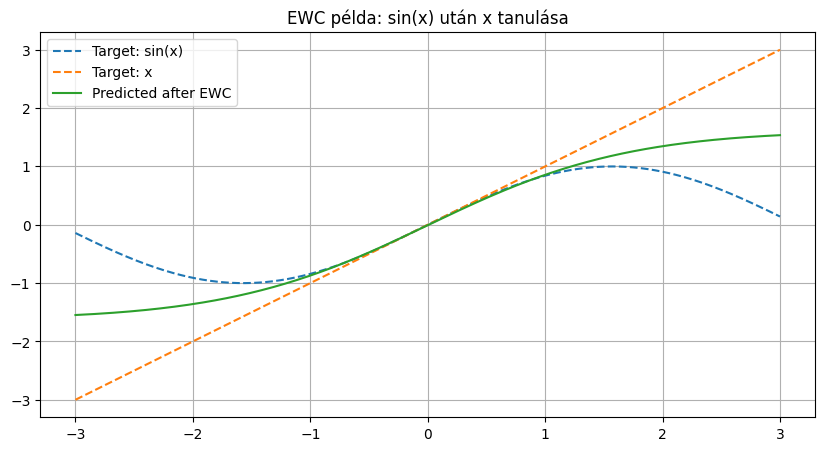

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Adat generálás ---
np.random.seed(0)
x_sin = np.linspace(-3, 3, 200).reshape(-1, 1)
y_sin = np.sin(x_sin)

x_lin = np.linspace(-3, 3, 200).reshape(-1, 1)
y_lin = x_lin

# --- 2. Egyszerű MLP modell ---
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='tanh', input_shape=(1,)),
        tf.keras.layers.Dense(1)
    ])
    return model

# --- 3. Fisher-információ becslés ---
def compute_fisher_information(model, x_data, y_data):
    fisher = []
    for var in model.trainable_variables:
        fisher.append(tf.zeros_like(var))

    for i in range(len(x_data)):
        x = x_data[i:i+1]
        y = y_data[i:i+1]

        with tf.GradientTape() as tape:
            y_pred = model(x)
            loss = tf.reduce_mean((y - y_pred) ** 2)
        grads = tape.gradient(loss, model.trainable_variables)

        for i in range(len(fisher)):
            fisher[i] += grads[i] ** 2

    fisher = [f / len(x_data) for f in fisher]
    return fisher

# --- 4. EWC loss ---
def ewc_loss_fn(model, x, y, fisher, optimal_weights, lambda_ewc=1000.0):
    with tf.GradientTape() as tape:
        preds = model(x)
        mse = tf.reduce_mean(tf.square(preds - y))

        ewc_penalty = 0.0
        for i, var in enumerate(model.trainable_variables):
            ewc_penalty += tf.reduce_sum(fisher[i] * tf.square(var - optimal_weights[i]))

        total_loss = mse + lambda_ewc * ewc_penalty
    grads = tape.gradient(total_loss, model.trainable_variables)
    return total_loss, grads

# --- 5. Tanítás ---
def train_standard(model, x, y, epochs=50):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            preds = model(x)
            loss = tf.reduce_mean(tf.square(preds - y))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

# --- 6. EWC tanítás ---
def train_with_ewc(model, x, y, fisher, old_weights, epochs=50):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    for epoch in range(epochs):
        loss, grads = ewc_loss_fn(model, x, y, fisher, old_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

# --- 7. Tréning és vizualizáció ---
model = build_model()
train_standard(model, tf.convert_to_tensor(x_sin, dtype=tf.float32), tf.convert_to_tensor(y_sin, dtype=tf.float32))

# Fisher-információ számítás (sin után)
fisher_info = compute_fisher_information(model, tf.convert_to_tensor(x_sin, dtype=tf.float32), tf.convert_to_tensor(y_sin, dtype=tf.float32))
old_weights = [tf.identity(w) for w in model.trainable_variables]

# Most tanuljuk a lineáris feladatot EWC-vel
train_with_ewc(model, tf.convert_to_tensor(x_lin, dtype=tf.float32), tf.convert_to_tensor(y_lin, dtype=tf.float32), fisher_info, old_weights)

# Előrejelzések
x_plot = np.linspace(-3, 3, 300).reshape(-1, 1)
y_pred_after = model.predict(x_plot)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_plot, np.sin(x_plot), label='Target: sin(x)', linestyle='--')
plt.plot(x_plot, x_plot, label='Target: x', linestyle='--')
plt.plot(x_plot, y_pred_after, label='Predicted after EWC')
plt.legend()
plt.title("EWC példa: sin(x) után x tanulása")
plt.grid(True)
plt.show()

Értelek. Én azt hittem, hogy szekvenciálisan fogjuk tanítani a neurális hálót a sinus hullámon úgy hogy mindig egy új adatot mutatunk neki és valahogy felhasználjuk ezt a fisher információt hogy a korábban megtanult súlyokból melyiket ne felejtse el. Végül egy animációban ábrázoljuk, hogyan alakult a tanulás ahogy a tanulási folyamat végig ment az egyre újabb és újabb adatokon. Mintha egy online tanulást szimuláltunk volna egy szinusz hullámon. De ezek szerint valamit én értettem félre.

Nem értettél félre — **amit te szeretnél, az teljesen értelmes, sőt izgalmasabb és realisztikusabb**, mint amit eddig mutattam. A félreértés inkább abban volt, hogy az első példám egy **klasszikus EWC-s szituációt** mutatott be (két teljes feladat egymás után), míg **te egy időben haladó, online tanulást szeretnél vizualizálni** EWC-vel kiegészítve.

---

## ✅ Amit te szeretnél:

### 👉 **Szimulált online tanulás `sin(x)` függvényen, pontonként**

* A háló **egyetlen pontot** lát egyszerre (`(x, sin(x))`)
* Minden új pont után:

  * frissíti a súlyokat
  * frissíti a Fisher-információ becslését
  * alkalmazza az EWC-penalizációt: az előző lépések alapján **védje a fontosabb súlyokat**
* Közben **vizualizáljuk**, hogyan változik a háló kimenete

Ez gyakorlatilag:
🎯 **„Online lifelong learning a `sin(x)` függvényen EWC-vel”**

---

## 🔍 Miben más ez?

| Jellemző        | Korábbi példa                | Te általad javasolt                |
| --------------- | ---------------------------- | ---------------------------------- |
| Tanulás típusa  | Batch, 2 külön feladat       | Online, pontonként jön a minta     |
| Fisher számítás | Egyben, sin(x) után          | Folyamatos, minta után frissül     |
| Vizualizáció    | Előtte/utána összehasonlítás | Animált, időben mutatja a tanulást |
| Realizmus       | Demonstráció                 | Online tanulás szimuláció          |

---

## 🛠️ Mi kell hozzá, hogy ezt megvalósítsuk?

1. 🧠 Egy MLP, ami `x → y` függvényt tanul
2. 🔁 Egy ciklus, amely minden `x_i` pont után:

   * kiszámítja a predikciót
   * kiszámítja a hibát
   * kiszámítja a gradienst
   * frissíti a Fisher-információt
   * alkalmazza az EWC-loss-t
   * frissíti a súlyokat
3. 📊 Minden `N` lépés után: vizualizálja az aktuális háló viselkedését a teljes `x` tartományon

---

## ❓ Kérdés:

Készen állsz, hogy ezt lépésenként elkezdjük implementálni egy új fájlban, animációval együtt?

Vagy előbb egy vázlatos pszeudokódot kérsz a teljes folyamatra, hogy biztosan lásd, mire vállalkozunk?

Mindkettőt szívesen csinálom!


Step 0, Loss: 0.0007
Step 20, Loss: 0.0002
Step 40, Loss: 0.0002
Step 60, Loss: 0.0001
Step 80, Loss: 0.0000
Step 100, Loss: 0.0000
Step 120, Loss: 0.0001
Step 140, Loss: 0.0006
Step 160, Loss: 0.0007
Step 180, Loss: 0.0002
Step 200, Loss: 0.0000
Step 220, Loss: 0.0000
Step 240, Loss: 0.0001
Step 260, Loss: 0.0002
Step 280, Loss: 0.0002


Text(0.5, 1.0, 'Online tanulás EWC-vel')

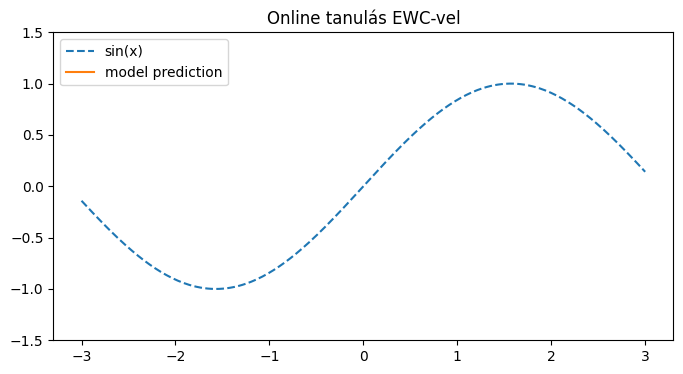

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# --- 1. Adat és beállítások ---
x_data = np.linspace(-3, 3, 300).reshape(-1, 1).astype(np.float32)
y_data = np.sin(x_data)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,)),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

# Fisher-információ kezdetben 0
fisher_info = [tf.zeros_like(var) for var in model.trainable_variables]
old_weights = [tf.identity(var) for var in model.trainable_variables]

lambda_ewc = 30.0

# --- 2. Loss + EWC ---
def compute_ewc_loss(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        mse_loss = tf.reduce_mean(tf.square(y - y_pred))

        ewc_penalty = 0.0
        for i, var in enumerate(model.trainable_variables):
            ewc_penalty += tf.reduce_sum(fisher_info[i] * tf.square(var - old_weights[i]))

        total_loss = mse_loss + lambda_ewc * ewc_penalty
    grads = tape.gradient(total_loss, model.trainable_variables)
    return total_loss, grads

# --- 3. Fisher frissítése ---
def update_fisher(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = tf.reduce_mean(tf.square(y - y_pred))
    grads = tape.gradient(loss, model.trainable_variables)

    for i in range(len(fisher_info)):
        fisher_info[i] = 0.9 * fisher_info[i] + 0.1 * (grads[i] ** 2)

# --- 4. Online tanítás és vizualizáció ---
x_plot = np.linspace(-3, 3, 300).reshape(-1, 1).astype(np.float32)
y_plot_true = np.sin(x_plot)
y_preds = []

for step in range(len(x_data)):
    x = tf.convert_to_tensor(x_data[step:step+1])
    y = tf.convert_to_tensor(y_data[step:step+1])

    loss, grads = compute_ewc_loss(x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    update_fisher(x, y)

    # minden 20. lépésben kiértékeljük a teljes függvényt
    if step % 20 == 0:
        y_pred_full = model(tf.convert_to_tensor(x_plot)).numpy()
        y_preds.append(y_pred_full)

        print(f"Step {step}, Loss: {loss.numpy():.4f}")

# --- 5. Animáció készítése ---
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 4))
line_true, = ax.plot(x_plot, y_plot_true, label='sin(x)', linestyle='--')
line_pred, = ax.plot([], [], label='model prediction')
ax.legend()
ax.set_ylim(-1.5, 1.5)
ax.set_title("Online tanulás EWC-vel")


In [4]:
def update(frame):
    line_pred.set_data(x_plot, y_preds[frame])
    ax.set_xlabel(f"Step: {frame * 20}")
    return line_pred,

ani = animation.FuncAnimation(fig, update, frames=len(y_preds), interval=300)
plt.show()

/home/ubuntu/notebook/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [11]:
import os

output_dir = "ewc_frames"
os.makedirs(output_dir, exist_ok=True)

j = 0
for i, step in enumerate(range(len(x_data))):
    x = tf.convert_to_tensor(x_data[step:step+1])
    y = tf.convert_to_tensor(y_data[step:step+1])

    loss, grads = compute_ewc_loss(x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    update_fisher(x, y)

    if step % 20 == 0:
        y_pred_full = model(tf.convert_to_tensor(x_plot)).numpy()
        y_preds.append(y_pred_full)

        # PNG mentés
        plt.figure(figsize=(8, 4))
        plt.plot(x_plot, y_plot_true, label='sin(x)', linestyle='--')
        plt.plot(x_plot, y_pred_full, label='model prediction')
        plt.title(f"Step {step}")
        plt.ylim(-1.5, 1.5)
        plt.legend()
        plt.grid(True)
        filename = os.path.join(output_dir, f"frame_{j:03d}.png")
        plt.savefig(filename)
        plt.close()
        j += 1


In [13]:
!ffmpeg -y -framerate 5 -i ewc_frames/frame_%03d.png -c:v libx264 -pix_fmt yuv420p ewc_learning.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [14]:
from IPython.display import Video
Video("ewc_learning.mp4")